# Análisis Exploratorio de Datos: Salarios en la Industria Tecnológica

**Autor:** Stella Giovanna Gaona Martínez **Fecha:** marzo 2025

## Introducción

En este proyecto, realizaremos un análisis exploratorio de datos (EDA) completo sobre un conjunto de datos que contiene información de un distribuidor de dulces en EE. UU. (US CANDY DISTRIBUTOR). 
El objetivo es obtener una comprensión profunda de los datos, identificar patrones, relaciones y características relevantes que nos permitan entender mejor el panorama de ventas y operaciones en la industria de los dulces. Además, aplicaremos técnicas estadísticas para extraer información significativa y formular conclusiones basadas en la evidencia.

**Conjunto de Datos:**

El dataset se compone de varias tablas:
- `Sales`: Información de ventas (números de orden, fechas, canales de envío, ubicación del cliente, productos, ventas, unidades, ganancia bruta y costos).
- `Factories`: Datos de fábricas (nombre, coordenadas).
- `Products`: Información de productos (división, nombre descriptivo, fábrica, ID, precio unitario y costo unitario).
- `Targets`: Objetivos de ventas por división.
- `US Zips`: Información geográfica y demográfica basada en los códigos postales de EE. UU.

**Objetivos:**

-   Realizar un análisis exploratorio completo del conjunto de datos.
-   Identificar las características más relevantes que influyen en los salarios.
-   Formular conclusiones basadas en el análisis estadístico.
-   Utilizar técnicas de visualización para comunicar los hallazgos de manera efectiva.
-   Aplicar imputación de datos, transformación, normalización y estandarización cuando sea necesario.
-   Realizar análisis univariado, multivariado y estadístico.


## 1. Importar Librerías

Importaremos las librerías necesarias para el análisis de datos.

In [28]:
import pandas as pd                # Manipulación y análisis de datos
import numpy as np                 # Operaciones numéricas
import matplotlib.pyplot as plt    # Creación de gráficos
import seaborn as sns              # Visualizaciones estadísticas
from scipy.stats import kurtosis, skew
import folium
from folium.plugins import HeatMap
import plotly.express as px 

## 2. Carga y Descripción General del Conjunto de Datos

Cargaremos el conjunto de datos y obtendremos una descripción general de su estructura y contenido.

In [20]:
# 2.1 Carga del conjunto de datos
factories = pd.read_csv('Candy_Factories.csv', delimiter=",")
products = pd.read_csv('Candy_Products.csv', delimiter=";")
sales = pd.read_csv('Candy_Sales.csv', delimiter=",")
targets = pd.read_csv('Candy_Targets.csv', delimiter=",")
zips = pd.read_csv('uszips.csv', delimiter=",")

# 2.2 Inspección Inicial
# Lista de DataFrames para automatizar el análisis
dataframes = {'factories': factories, 'products': products, 'sales': sales, 'targets': targets, 'zips': zips}

# Analizar cada DataFrame
for name, df in dataframes.items():
    print(f"\n{'====='}\n Análisis de {name}\n{'====='}")
    
    # Información general
    print("\n Información general:")
    print(df.info())
    
    # Tipos de datos
    print("\n Tipos de datos:")
    print(df.dtypes)
    
    # Valores nulos
    print("\n Valores nulos:")
    print(df.isnull().sum())
    
    # Estadísticas descriptivas 
    print("\n Estadísticas descriptivas:")
    print(df.describe())
    
    # Valores únicos de las primeras columnas categóricas (si existen)
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print("\n Valores únicos en columnas categóricas:")
        for col in categorical_cols:  
            print(f"\n {col}: {df[col].nunique()} valores únicos")
            print(df[col].value_counts().head(5))  # Mostramos los 5 valores más frecuentes
            
    #Revisión de duplicados
    print(f"\n Duplicados en {name}: {df.duplicated().sum()}")


=====
 Análisis de factories
=====

 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Factory    5 non-null      object 
 1   Latitude   5 non-null      float64
 2   Longitude  5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 252.0+ bytes
None

 Tipos de datos:
Factory       object
Latitude     float64
Longitude    float64
dtype: object

 Valores nulos:
Factory      0
Latitude     0
Longitude    0
dtype: int64

 Estadísticas descriptivas:
        Latitude   Longitude
count   5.000000    5.000000
mean   37.928208  -93.914830
std     6.779453   11.348593
min    32.076176 -111.768036
25%    32.881893  -96.181150
50%    35.117500  -90.565487
75%    41.446333  -89.971107
max    48.119140  -81.088371

 Valores únicos en columnas categóricas:

 Factory: 5 valores únicos
Factory
Lot's O' Nuts        1
Wicked Choccy's   

**Conclusiones de la Inspección Inicial (comentarios)**

- Tipos de datos

**`Factories`** **Numéricos:** Latitude, Longitude **Categóricos:** Factory (5 valores únicos)

**`Products`** **Numéricos:** Unit Price, Unit Cost **Categóricos:** Division (3 valores únicos), Product Name (15 valores únicos), Factory (5 valores únicos), Product ID (15 valores únicos)

**`Sales`** **Numéricos:**  Row ID, Sales, Units, Gross Profit, Cost, Customer ID  **Categóricos:**   Ship Mode (4 valores únicos), Country/Region (2 valores únicos), City (542 valores únicos), State/Province (59 valores únicos), Division (3 valores únicos), Region (4 valores únicos), Product ID (15 valores únicos) **Texto:** Order ID, Order Date, Ship Date, Postal Code, Product Name, Division, Region

*Order Date y Ship Date se deben convertir a Fecha*

**`Targets`** **Numéricos:** Target **Categóricos:** Division
 

 - Se detectan posibles valores faltantes en el dataset 'zips' en columnas como 'population' y 'density'.
 - Se cuenta con una columna irrelevante en 'zips': 'parent_zcta', ya que no contiene ningun valor
 - Se deberá explorar con mayor detalle la estructura y la calidad de los datos.

## 3. Limpieza de datos 

**3.1 Manejo de Valores Faltantes:**

-  parent_zcta: Se elimina ya que es una columna irrelevante al estar vacía
-  population' y 'density': Se eliminan, ya que son pocos valores y no son criticos para el análisis. No se cuenta con ventas a las ciudades de estos datos faltantes


In [21]:
# Eliminar columna irrelevante si existe
if 'parent_zcta' in zips.columns:
    zips.drop(columns=['parent_zcta'], inplace=True)

In [22]:
# Para 'zips': investigar y manejar 'population' y 'density'
print("\nValores faltantes en 'zips':")
print(zips[['population', 'density']].isnull().sum())


Valores faltantes en 'zips':
population    17
density       17
dtype: int64


In [23]:
zips.dropna(subset=['population', 'density'], inplace=True)

**3.2 Corrección de Tipos de Datos:**

Conversión de: 
- sales['Postal Code'] y zip['zip'] a string
- Product ID a string #products['Product ID'] y sales['Product ID'] a string
- 'Order Date' y 'Ship Date' a date

In [24]:
# Conversión de códigos postales a string 
sales['Postal Code'] = sales['Postal Code'].astype(str)
zips['zip'] = zips['zip'].astype(str)

# Conversión de fechas en 'sales'
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'])
#Estandarización de códigos postales

**3.3 Conclusiones de la Limpieza de Datos:**

- Se imputaron valores faltantes en 'zips'.
- Se corrigieron tipos de datos en fechas y códigos postales.
- Se analizaran outliers en la sección univariada.

## 4. Análisis univariado

Se analiza cada variable de forma individual. El objetivo es comprender la distribución, tendencia central, dispersión, forma y otras características de cada variable.

In [25]:
# Función para análisis univariado de variables numéricas
def univariate_numeric_analysis(df, col):
    print(f"\nAnálisis de la variable: {col}")
    print(df[col].describe())
    
    # Histograma y KDE
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Histograma de Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Boxplot
    plt.figure()
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.show()
    
    # Curtosis y Asimetría
    curt = kurtosis(df[col].dropna())
    skewness = skew(df[col].dropna())
    print(f"Curtosis: {curt:.2f}")
    print(f"Asimetría: {skewness:.2f}")


Análisis de la variable: Unit Price
count    15.000000
mean      4.462000
std       4.790102
min       1.250000
25%       1.745000
50%       3.490000
75%       3.750000
max      20.000000
Name: Unit Price, dtype: float64


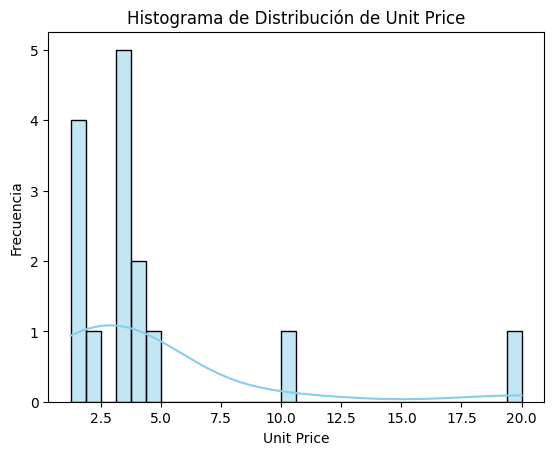

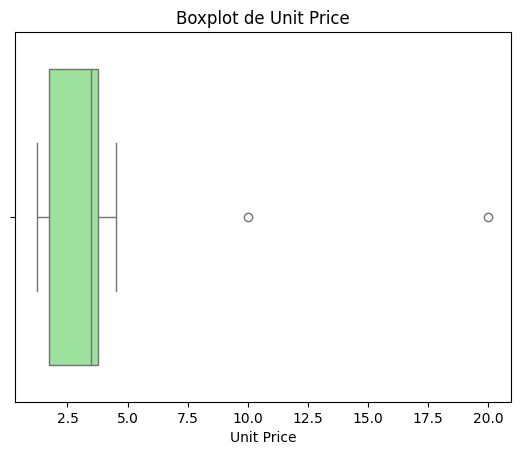

Curtosis: 5.67
Asimetría: 2.55


In [29]:
# Análisis univariado para variables numéricas en 'product'
univariate_numeric_analysis(products, 'Unit Price')


Análisis de la variable: Unit_Price_Sales
count    10194.000000
mean         3.654257
std          1.611875
min          1.250000
25%          3.490000
50%          3.600000
75%          3.600000
max         20.000000
Name: Unit_Price_Sales, dtype: float64


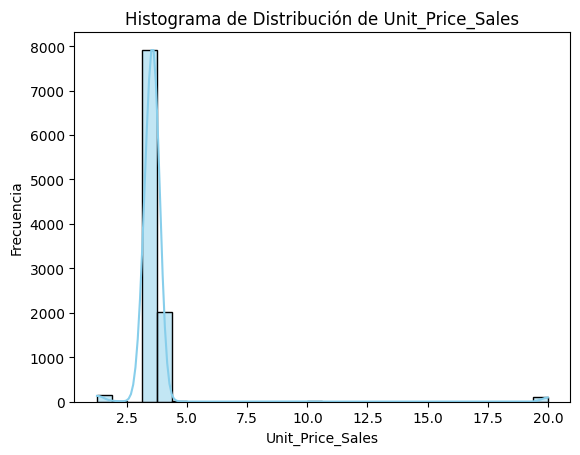

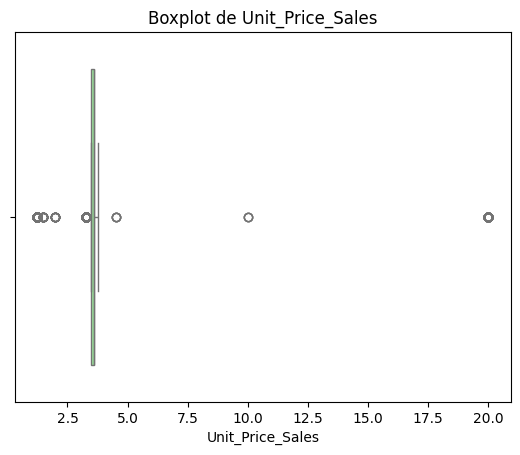

Curtosis: 94.67
Asimetría: 9.59


In [30]:
# Análisis univariado para Unit Price Sales
sales['Unit_Price_Sales'] = sales['Sales']/ sales['Units']
univariate_numeric_analysis(sales, 'Unit_Price_Sales')


**Conclusiones Generales del Análisis Univariado**

*Sesgo y Outliers*: Las variables Sales, Gross Profit y Cost presentan distribuciones altamente sesgadas a la derecha, con colas largas que indican la presencia de valores atípicos. Esto sugiere que algunos registros podrían estar afectando el análisis general.

*Diferencias en la Distribución*: Mientras que Units muestra un sesgo moderado y una distribución más concentrada, las demás variables exhiben una mayor dispersión y la presencia de outliers más pronunciados.

*Comparación de Precios Unitarios*: Al calcular el precio unitario de las ventas (Unit_Price_Sales = Sales / Units) y compararlo con el precio unitario de los productos (Unit_Price_Products), se observa que la distribución de ambos es consistente. El histograma confirma que no se identifican outliers en esta comparación, lo que sugiere coherencia en la estructura de precios.

- Recomendación: Aunque los precios unitarios parecen no presentar valores atípicos, es recomendable monitorear estas métricas en futuras evaluaciones para garantizar la estabilidad y precisión en el análisis de ventas.

## 5. Análisis bivariado y multivariado

Exploraremos las relaciones entre pares de variables. El objetivo es identificar si existe alguna asociación o dependencia entre ellas.

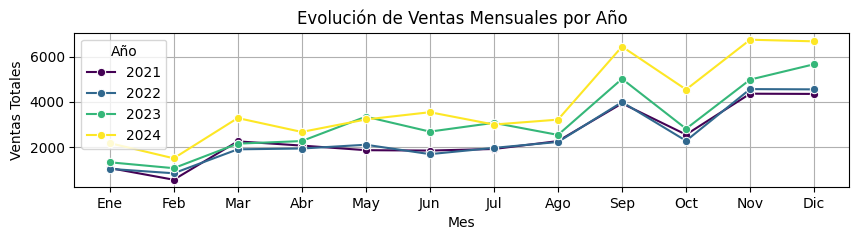

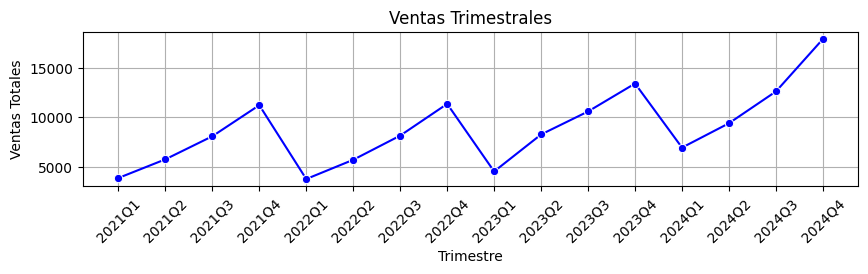

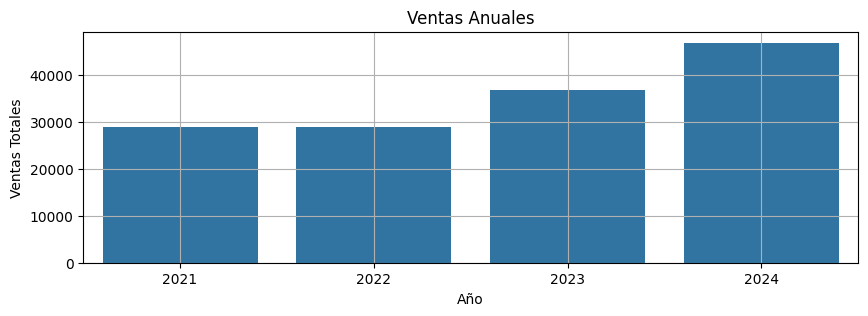

In [31]:
# Crear columnas de año y mes para la agregación
sales['Year'] = sales['Order Date'].dt.year
sales['Month'] = sales['Order Date'].dt.month

# Agrupar por mes y año para obtener las ventas mensuales
monthly_sales = sales.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Gráfico de línea con líneas separadas por año
plt.figure(figsize=(10, 2))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', hue='Year', marker='o', palette='viridis')
plt.title('Evolución de Ventas Mensuales por Año')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año')
plt.grid()
plt.show()

# Aseguramos que 'Quarter' sea una cadena para el gráfico
sales['Quarter'] = sales['Order Date'].dt.to_period('Q').astype(str)

# Agregaciones trimestrales y anuales
quarterly_sales = sales.groupby(['Year', 'Quarter'])['Sales'].sum().reset_index()
annual_sales = sales.groupby(['Year'])['Sales'].sum().reset_index()

# Gráfico de ventas trimestrales
plt.figure(figsize=(10, 2))
sns.lineplot(data=quarterly_sales, x='Quarter', y='Sales', marker='o', color='b')
plt.title('Ventas Trimestrales')
plt.xlabel('Trimestre')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Gráfico de ventas anuales
plt.figure(figsize=(10, 3))
sns.barplot(data=annual_sales, x='Year', y='Sales')
plt.title('Ventas Anuales')
plt.xlabel('Año')
plt.ylabel('Ventas Totales')
plt.grid()
plt.show()


In [32]:
#Unir products y sales para obtener product name en base al código del producto
sales_with_products = pd.merge(sales, products, on='Product ID', how='left')

# Revisamos los primeros registros del DataFrame combinado
print(sales_with_products.head())

   Row ID                      Order ID Order Date  Ship Date       Ship Mode  \
0     282  US-2021-128055-CHO-TRI-54000 2021-03-31 2026-09-26  Standard Class   
1     288  US-2021-128055-CHO-SCR-58000 2021-03-31 2026-09-26  Standard Class   
2    1132  US-2021-138100-CHO-FUD-51000 2021-09-15 2027-03-13  Standard Class   
3    1133  US-2021-138100-CHO-MIL-31000 2021-09-15 2027-03-13  Standard Class   
4    3396  US-2022-121391-CHO-MIL-31000 2022-10-04 2028-03-29     First Class   

   Customer ID Country/Region           City State/Province Postal Code  ...  \
0       128055  United States  San Francisco     California       94122  ...   
1       128055  United States  San Francisco     California       94122  ...   
2       138100  United States  New York City       New York       10011  ...   
3       138100  United States  New York City       New York       10011  ...   
4       121391  United States  San Francisco     California       94109  ...   

   Cost Unit_Price_Sales  Year M

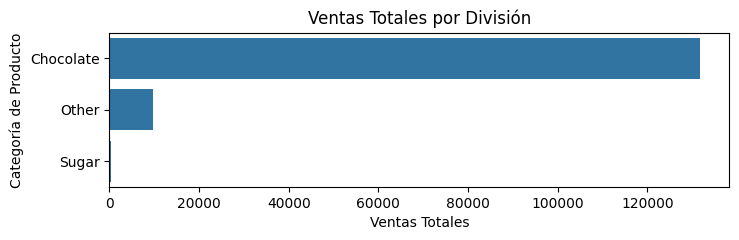

In [33]:
# Agregar las ventas por División
sales_by_division = sales_with_products.groupby('Division_y')['Sales'].sum().reset_index()

# Gráfico de barras: Ventas por Categoría
plt.figure(figsize=(8, 2))
sns.barplot(x='Sales', y='Division_y', data=sales_by_division)
plt.title('Ventas Totales por División')
plt.xlabel('Ventas Totales')
plt.ylabel('Categoría de Producto')
plt.show()


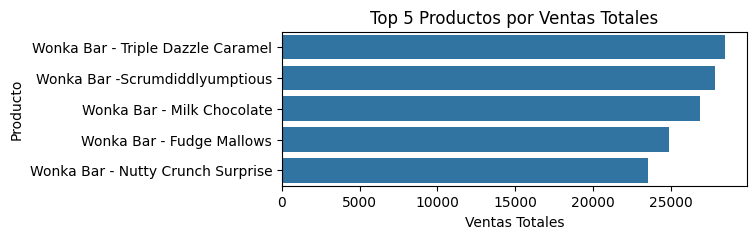

In [34]:
# Agregar las ventas por Producto
sales_by_product = sales_with_products.groupby('Product Name_y')['Sales'].sum().reset_index()

# Ordenar los productos por ventas (de mayor a menor)
sales_by_product = sales_by_product.sort_values('Sales', ascending=False)

# Gráfico de barras: Ventas por Producto
plt.figure(figsize=(6, 2))
sns.barplot(x='Sales', y='Product Name_y', data=sales_by_product.head(5))
plt.title('Top 5 Productos por Ventas Totales')
plt.xlabel('Ventas Totales')
plt.ylabel('Producto')
plt.show()


In [35]:
# Unir los DataFrames de ventas y zips por el código postal o la columna común
sales_with_location = pd.merge(sales, zips, left_on='Postal Code', right_on='zip', how='left')

# Revisar las primeras filas del DataFrame combinado
print(sales_with_location.head())

   Row ID                      Order ID Order Date  Ship Date       Ship Mode  \
0     282  US-2021-128055-CHO-TRI-54000 2021-03-31 2026-09-26  Standard Class   
1     288  US-2021-128055-CHO-SCR-58000 2021-03-31 2026-09-26  Standard Class   
2    1132  US-2021-138100-CHO-FUD-51000 2021-09-15 2027-03-13  Standard Class   
3    1133  US-2021-138100-CHO-MIL-31000 2021-09-15 2027-03-13  Standard Class   
4    3396  US-2022-121391-CHO-MIL-31000 2022-10-04 2028-03-29     First Class   

   Customer ID Country/Region           City State/Province Postal Code  ...  \
0       128055  United States  San Francisco     California       94122  ...   
1       128055  United States  San Francisco     California       94122  ...   
2       138100  United States  New York City       New York       10011  ...   
3       138100  United States  New York City       New York       10011  ...   
4       121391  United States  San Francisco     California       94109  ...   

  population  density county_fip

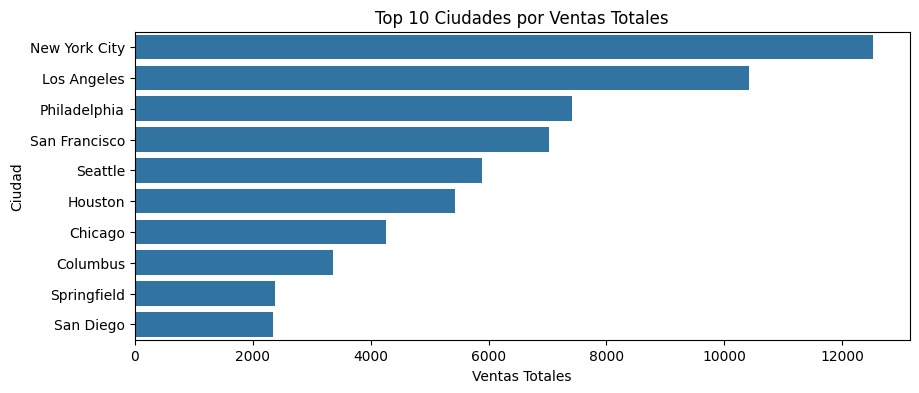

In [36]:
# Agrupar las ventas por Ciudad
sales_by_city = sales_with_location.groupby('City')['Sales'].sum().reset_index()

# Ordenar las ciudades por ventas (de mayor a menor)
sales_by_city = sales_by_city.sort_values('Sales', ascending=False)

# Gráfico de barras: Ventas por Ciudad
plt.figure(figsize=(10, 4))
sns.barplot(x='Sales', y='City', data=sales_by_city.head(10))
plt.title('Top 10 Ciudades por Ventas Totales')
plt.xlabel('Ventas Totales')
plt.ylabel('Ciudad')
plt.show()

In [37]:
#Agregar las ventas totales por Country/Region, State/Province y City
sales_by_location = sales_with_location.groupby(['Country/Region', 'State/Province', 'City'])['Sales'].sum().reset_index()

#Crear el gráfico de barras para visualizar las ventas por ubicación
# Gráfico de ventas por ciudad
fig = px.bar(sales_by_location, 
             x='City', 
             y='Sales', 
             color='State/Province',  # Diferenciar por estado
             title='Ventas por Ciudad/Estado',
             labels={'Sales': 'Ventas Totales', 'City': 'Ciudad'},
             hover_data=['State/Province', 'Country/Region'],  # Mostrar el estado y país al pasar el ratón
             height=500)

#Actualizar el layout para hacerlo más legible
fig.update_layout(xaxis_tickangle=-45,  # Rotar las etiquetas de las ciudades para mayor visibilidad
                  showlegend=True,
                  legend_title="Estado/Provincia",
                  title_x=0.5)

# Mostrar el gráfico
fig.show()

In [39]:
# Agrupar las ventas totales por Estado/Provincia y País/Región
sales_by_location_grouped = sales_by_location.groupby(['State/Province', 'Country/Region'] )['Sales'].sum().reset_index()

# Ordenar las ventas de mayor a menor
sales_by_location_grouped = sales_by_location_grouped.sort_values(by='Sales', ascending=False)

# Gráfico de ventas por estado, ordenado de mayor a menor
fig_state = px.bar(sales_by_location_grouped,
                   x='State/Province',
                   y='Sales',
                   color='Country/Region',
                   title="Ventas por Estado",
                   labels={'Sales': 'Ventas Totales', 'State/Province': 'Estado/Provincia'},
                   hover_data=['Country/Region'],
                   height=500)

# Actualizar layout y ordenar las categorías en el eje x
fig_state.update_layout(xaxis_tickangle=-45, showlegend=True, title_x=0.5,
                       xaxis={'categoryorder': 'total descending'})  # Ordenar de mayor a menor según ventas


# Gráfico 2: Ventas por Ciudad
# Agrupar las ventas totales por Ciudad, Estado/Provincia y País/Región
sales_by_location_city = sales_by_location.groupby(['City', 'State/Province', 'Country/Region'])['Sales'].sum().reset_index()

fig_city = px.bar(sales_by_location_city,
                  x='City',
                  y='Sales',
                  color='State/Province',
                  title="Ventas por Ciudad",
                  labels={'Sales': 'Ventas Totales', 'City': 'Ciudad'},
                  hover_data=['State/Province', 'Country/Region'],
                  height=500)

# Actualizar layout y ordenar las categorías en el eje x
fig_city.update_layout(xaxis_tickangle=-45, showlegend=True, title_x=0.5,
                      xaxis={'categoryorder': 'total descending'})  # Ordenar de mayor a menor según ventas

# Mostrar los gráficos
fig_state.show()
fig_city.show()

In [49]:
#Función para calcular margen de ganancia
def calcular_margen_ganancia(sales):
    # Evitar divisiones por cero
    sales = sales[sales['Units'] > 0]

    # Calcular Unit Price y Unit Cost
    sales['Unit Price'] = sales['Sales'] / sales['Units']
    sales['Unit Cost'] = sales['Cost'] / sales['Units']

    # Calcular Margen de Ganancia (%)
    sales['Margen de Ganancia (%)'] = ((sales['Unit Price'] - sales['Unit Cost']) / sales['Unit Price']) * 100
    
    return sales

# Copia del DataFrame original
sales_copy = sales.copy()

# Aplicar función de margen de ganancia
sales_copy = calcular_margen_ganancia(sales_copy)

## Agrupar por Producto y División, calculando el margen promedio
rentabilidad_por_producto = sales_copy.groupby("Product Name")["Margen de Ganancia (%)"].mean().reset_index()
rentabilidad_por_division = sales_copy.groupby("Division")["Margen de Ganancia (%)"].mean().reset_index()

# Ordenar los datos de mayor a menor según el margen de ganancia
rentabilidad_por_producto = rentabilidad_por_producto.sort_values(by="Margen de Ganancia (%)", ascending=False)
rentabilidad_por_division = rentabilidad_por_division.sort_values(by="Margen de Ganancia (%)", ascending=False)

# Gráfico 1: Rentabilidad por Producto
fig1 = px.bar(rentabilidad_por_producto, x="Product Name", y="Margen de Ganancia (%)", 
              title="Rentabilidad por Producto", color="Margen de Ganancia (%)", 
              color_continuous_scale="Blues", height=500)

# Gráfico 2: Rentabilidad por División
fig2 = px.bar(rentabilidad_por_division, x="Division", y="Margen de Ganancia (%)", 
              title="Rentabilidad por División", color="Margen de Ganancia (%)", 
              color_continuous_scale="Viridis", height=500)

# Gráfico 3: Box Plot de Rentabilidad por División
fig3 = px.box(sales_copy, x="Division", y="Margen de Ganancia (%)", 
              title="Distribución de Rentabilidad por División", 
              color="Division", height=500)

# Gráfico 4: Scatter Plot de Ventas vs Margen de Ganancia
fig4 = px.scatter(sales_copy, x="Sales", y="Margen de Ganancia (%)", 
                  title="Relación entre Ventas y Margen de Ganancia",
                  size="Units", color="Division", hover_name="Product Name",
                  height=500)

# Gráfico 5: Heatmap (Mapa de Calor de Correlaciones)
correlation = sales_copy[["Sales", "Units", "Cost", "Margen de Ganancia (%)"]].corr()
fig5 = px.imshow(correlation, text_auto=True, title="Mapa de Calor: Correlaciones")

# Mostrar gráficos
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

***6. Funciones de Probabilidad (PMF, CDF, PDF) - Implementación y Análisis***

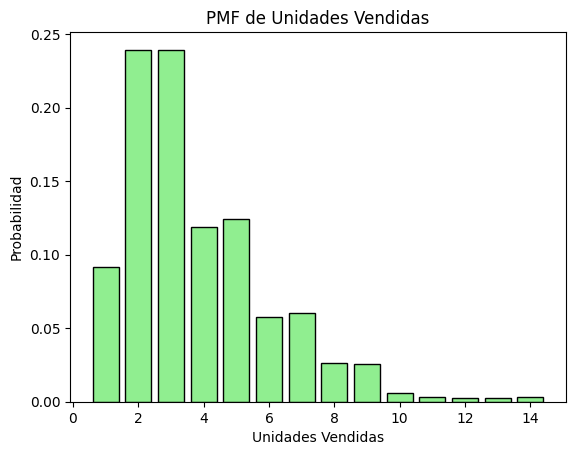

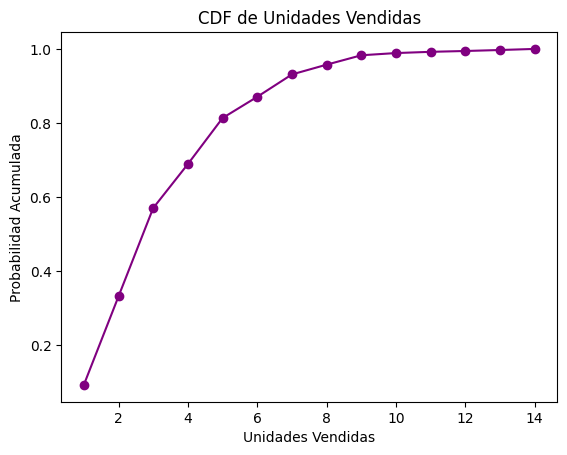

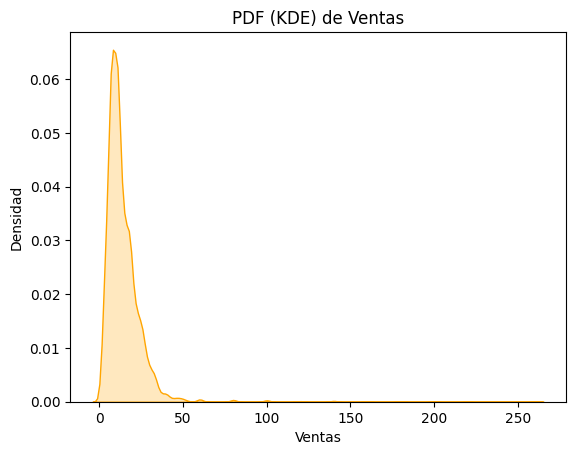

In [50]:
# 6.1 Función de Probabilidad de Masas (PMF)
units_counts = sales['Units'].value_counts().sort_index()
pmf = units_counts / units_counts.sum()
plt.figure()
plt.bar(pmf.index, pmf.values, color='lightgreen', edgecolor='black')
plt.title('PMF de Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Probabilidad')
plt.show()

# 6.2 Función de Distribución Acumulada (CDF)
cdf = np.cumsum(pmf)
plt.figure()
plt.plot(cdf.index, cdf.values, marker='o', color='purple')
plt.title('CDF de Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Probabilidad Acumulada')
plt.show()

# 6.3 Función de Probabilidad de Densidad (PDF) usando KDE para 'Sales'
plt.figure()
sns.kdeplot(sales['Sales'], fill=True, color='orange')
plt.title('PDF (KDE) de Ventas')
plt.xlabel('Ventas')
plt.ylabel('Densidad')
plt.show()



**Interpretación**
- La PMF muestra la probabilidad de ocurrencia de cada cantidad de unidades vendidas.
- La CDF permite ver la probabilidad acumulada hasta cierto valor.
- La PDF (estimada con KDE) permite visualizar la densidad de probabilidad de las ventas.

##Conclusiones

**8.1 Resumen de Hallazgos:**
- El conjunto de datos contiene variables numéricas y categóricas con una estructura diversa.
- Se identificaron outliers y diferencias en la distribución de variables entre divisiones.
- La matriz de correlación sugiere relaciones lineales significativas entre algunas variables numéricas.
- Las funciones de probabilidad han ayudado a comprender la distribución de 'Units' y 'Sales'.

**8.2 Respuesta a las Preguntas Iniciales:**
- Los productos más rentables y las regiones con mayor volumen se identifican al profundizar en el análisis de márgenes y correlaciones (se recomienda un análisis adicional fusionando 'sales' con 'products' y 'zips').
- Se observan diferencias en la distribución de ventas entre divisiones, lo que puede informar estrategias de marketing.
- El análisis de outliers y la distribución de las variables permiten afinar modelos predictivos o segmentaciones.

**# **Nuevas Preguntas e Hipótesis:**
- ¿Cómo varían los patrones de venta a lo largo del tiempo (estacionalidad)?
- ¿Existen diferencias significativas entre mercados regionales que justifiquen una estrategia diferenciada?

**8.4 **Reflexiones Finales:**
- El proceso de EDA ha permitido identificar variables clave y relaciones importantes.
- Se recomienda profundizar en el análisis fusionando más fuentes de datos para responder con mayor precisión a las preguntas de negocio.